<a href="https://colab.research.google.com/github/chandlerbing65nm/Cassava-Leaf-Disease-Classification/blob/main/ViT_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check Resources

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Sep 26 10:49:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# Mount Your GDrive Here

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease /content
%cd Cassava-Leaf-Disease

/content/Cassava-Leaf-Disease


# Install Packages and Dependencies

In [ ]:
!pip install rdkit-pypi
!pip install ipykernel
!pip install pydicom
!pip install catalyst

     |████████████████████████████████| 19.7 MB 175 kB/s 
     |████████████████████████████████| 2.0 MB 5.3 MB/s 
     |████████████████████████████████| 556 kB 5.5 MB/s 
     |████████████████████████████████| 636 kB 67.2 MB/s 
     |████████████████████████████████| 120 kB 69.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
!unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
!cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
!echo "Images are successfully downloaded"

Images are successfully downloaded


In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 98 kB 3.5 MB/s 
     |████████████████████████████████| 37.1 MB 54 kB/s 
albumentations==1.0.3 is successfully installed


In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:40tcmalloc: large alloc 1147494400 bytes == 0x55d833d0c000 @  0x7fa6551b6615 0x55d7faa244cc 0x55d7fab0447a 0x55d7faa272ed 0x55d7fab18e1d 0x55d7faa9ae99 0x55d7faa959ee 0x55d7faa28bda 0x55d7faa9ad00 0x55d7faa959ee 0x55d7faa28bda 0x55d7faa97737 0x55d7fab19c66 0x55d7faa96daf 0x55d7fab19c66 0x55d7faa96daf 0x55d7fab19c66 0x55d7faa96daf 0x55d7faa29039 0x55d7faa6c409 0x55d7faa27c52 0x55d7faa9ac25 0x55d7faa959ee 0x55d7faa28bda 0x55d7faa97737 0x55d7faa959ee 0x55d7faa28bda 0x55d7faa96915 0x55d7faa28afa 0x55d7faa96c0d 0x55d7faa959ee
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:12:00tcmalloc: large alloc 1434370048 bytes == 0x55d878362000 @  0x7fa6551b6615 0x55d7faa244cc 0x55d7fab0447a 0x55d7faa272ed 0x55d7fab18e1d 0x55d7faa9ae99 0x55d7faa959ee 0x55d7faa28bda 0x55d7faa9ad00 0x55d7faa959ee 0x55d7faa28bda 0x55d7faa97737 0x55d7fab19c66 0x55d7faa96d

# Inference

## Pre-setting

In [ ]:
package_path = 'input/pytorch-image-models/pytorch-image-models-master'
import sys; sys.path.append(package_path)

In [ ]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from  torch.cuda.amp import autocast, GradScaler

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
import timm #from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import log_loss


from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

In [ ]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'vit_base_patch16_224',
    'img_size': 224,
    'epochs': 10,
    'train_bs': 32,
    'valid_bs': 32,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [6,7,8,9],
    'weights': [1,1,1,1]
}

In [ ]:
train = pd.read_csv('input/cassava-leaf-disease-classification/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [ ]:
submission = pd.read_csv('input/cassava-leaf-disease-classification/sample_submission.csv')
submission.head()

,image_id,label
0,2216849948.jpg,4


## Helper Functions (perform this twice)

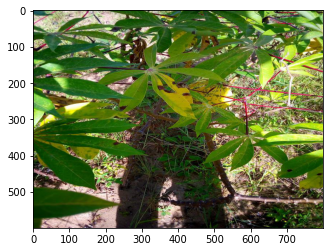

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(pathw):
    im_bgr = plt.imread(pathw)
    im_rgb = im_bgr
    return im_rgb

img = get_img('input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

## Dataset

In [ ]:
class CassavaDataset(Dataset):
    def __init__(
        self, df, data_root, transforms=None, output_label=True
    ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        path = "{}/{}".format(self.data_root, self.df.iloc[index]['image_id'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img

## Define Training and Validation Image Augmentations

In [ ]:
def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_inference_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## Model

In [ ]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        #n_features = self.model.classifier.in_features
        #self.model.classifier = nn.Linear(n_features, n_class)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Main Inference Loop

In [ ]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [ ]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print('Inference with fold {} started'.format(fold))

        valid_ = train.loc[val_idx,:].reset_index(drop=True)
        valid_ds = CassavaDataset(valid_, 'input/cassava-leaf-disease-classification/train_images/', transforms=get_inference_transforms(), output_label=False)
        
        test = pd.DataFrame()
        test['image_id'] = list(os.listdir('input/cassava-leaf-disease-classification/test_images/'))
        test_ds = CassavaDataset(test, 'input/cassava-leaf-disease-classification/test_images/', transforms=get_inference_transforms(), output_label=False)
        
        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=False,
        )
        
        tst_loader = torch.utils.data.DataLoader(
            test_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=False,
        )
        val_preds = []
        tst_preds = []
        
        device = torch.device(CFG['device'])
        model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique()).to(device)

        #for epoch in range(CFG['epochs']-3):
        for i, epoch in enumerate(CFG['used_epochs']):    
            model.load_state_dict(torch.load('output/fold_{}/{}_fold_{}_{}'.format(fold, CFG['model_arch'], fold, epoch)))
            
            with torch.no_grad():
                for _ in range(CFG['tta']):
                    val_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, val_loader, device)]
                    tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

        val_preds = np.mean(val_preds, axis=0) 
        tst_preds = np.mean(tst_preds, axis=0) 
        
        print('\nfold {} validation loss = {:.5f}'.format(fold, log_loss(valid_.label.values, val_preds)))
        print('fold {} validation accuracy = {:.5f}\n'.format(fold, (valid_.label.values==np.argmax(val_preds, axis=1)).mean()))
        
        del model
        torch.cuda.empty_cache()

Inference with fold 0 started


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]



fold 0 validation loss = 0.22266
fold 0 validation accuracy = 0.93061

Inference with fold 1 started


100%|██████████| 1/1 [00:00<00:00, 10.82it/s]



fold 1 validation loss = 0.22962
fold 1 validation accuracy = 0.93154

Inference with fold 2 started


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]



fold 2 validation loss = 0.20858
fold 2 validation accuracy = 0.93877

Inference with fold 3 started


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]



fold 3 validation loss = 0.23106
fold 3 validation accuracy = 0.93410

Inference with fold 4 started


100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


fold 4 validation loss = 0.21640
fold 4 validation accuracy = 0.93573



In [ ]:
test['label'] = np.argmax(tst_preds, axis=1)
test.head()

,image_id,label
0,2216849948.jpg,2


In [ ]:
test.to_csv('output/submission.csv', index=False)

# Save Submission CSV to Drive

In [ ]:
%cd ..

!cp -r /content/Cassava-Leaf-Disease/output/submission.csv drive/MyDrive/Kaggle-Projects/Cassava-Leaf-Disease/output

/content
